# Covid-19 prediction using LSTM
I took dataset from given source below and used LSTM to predict cases in future on base of previous model learning. I observed there are peaks in dataset graph so we can find better predictions based on those peaks. <br>

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fetching and cleaning data

In [6]:
# download contineous updated data
country = 'US'
#country = 'Albania'
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
confirmed = df[df['Country/Region'] == country]  #select specific country
confirmed = confirmed.T  #swap row into columns
confirmed.drop(confirmed.head(4).index, inplace = True)   #drop first rows not needed
confirmed.index = pd.to_datetime(confirmed.index)  #formate date column
confirmed.rename(columns={confirmed.columns[0]:'confirmed'}, inplace = True) # rename column by index
confirmed.dropna(inplace=True) # drops null values

print(confirmed.shape)
confirmed.tail()

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

#### Plot all data base on Data Frame

In [ ]:
confirmed.plot(figsize= (10,6), title = country + ' Covid-19 data')

#### Split dataset into training and testing
Split last 21 days for testing and rest (592-21 = 571) for training

In [ ]:
# training and testing use until last 21 days for training 
total_cases = confirmed['confirmed']
all_dates = pd.to_datetime(confirmed.index)

x =  len(confirmed) - 21  # last 21 days for testing
train =confirmed.iloc[:x]
test = confirmed.iloc[x:]

train_dates = pd.to_datetime(train.index)
test_dates = pd.to_datetime(test.index)
print(train.shape)
print(test.shape)
print(total_cases.shape)
print(all_dates.shape)

# 2. Scaling data

I used MinMaxscaler which <b><i>scales and translates each feature individually such that it is in the given range on the training set</b></i>, e.g between zero and one and Transformation is given by: <br>
<div>
<img src="scale.png" width="200"/>
</div>
Formula: <br>

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))<br>
X_scaled = X_std * (max - min) + min

<br>
<h3> <font color="red">Axis in Data Frame concept </font></h3>
A DataFrame object has two axes: “axis 0” and “axis 1”. “axis 0” represents rows and “axis 1” represents columns. Now it’s clear that Series and DataFrame share the same direction for “axis 0” – it goes along rows direction
<div>
    <img src='axes.png' width="50%" height="50%" align="left">
</div>
<br>


In [ ]:
# Scalling 
scaler = MinMaxScaler()
scaler.fit(confirmed)

scale_train = scaler.transform(confirmed)
scale_test = scaler.transform(test)

# 3. Generating time series and windowing

In [ ]:
# Time series generator to generate data in sequence 
# Sequence has and impact on prediction 
seq_size = 6   #number of steps lookback 
n_features = 1  # no. of features this dataset is univariate so only one feature
train_generator = TimeseriesGenerator(scale_train, scale_train, length = seq_size, batch_size=1) # batch= variables
print('No of samples in origional training data: ', len(train)) # 571
print('No of samples in train generated data: ', len(train_generator)) #564
x,y = train_generator[10]   # get x and y lets say 10th generator


test_generator = TimeseriesGenerator(scale_test, scale_test, length = seq_size, batch_size=1)
print('total samples after scaling in test series', len(scale_test)) #70
print('total samples in test generator', len(test_generator)) #63

a, b = test_generator[:] #print for visualizing
b

### Time Series generation without use of     "TimeSeriesGenerator"

In [7]:

'''
#skip
trainX = []
trainY = []

seq_size = 6   #number of steps lookback 
n_features = 1  # no. of features this dataset is univariate so only one feature

for i in range(seq_size, len(scale_train) - n_features +1):
    trainX.append(scale_train[i - seq_size:i, 0:train.shape[1]])
    trainY.append(scale_train[i, 0])

trainX = np.array(trainX)
trainY = np.array(trainY)
len(trainY)
'''

'\n#skip\ntrainX = []\ntrainY = []\n\nseq_size = 6   #number of steps lookback \nn_features = 1  # no. of features this dataset is univariate so only one feature\n\nfor i in range(seq_size, len(scale_train) - n_features +1):\n    trainX.append(scale_train[i - seq_size:i, 0:train.shape[1]])\n    trainY.append(scale_train[i, 0])\n\ntrainX = np.array(trainX)\ntrainY = np.array(trainY)\nlen(trainY)\n'

# 4. Design LSTM Model

In [8]:
# modeling 
model = Sequential()
model.add(LSTM(150, activation = 'relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation = 'relu', return_sequences=False))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 150)            91200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [9]:
# fit generator in time series case
history  = model.fit_generator(train_generator,
                     validation_data = test_generator,
                     verbose=1,
                     epochs=20,
                     steps_per_epoch=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
10/10 [==============================] - 0s 32ms/step - loss: 0.1854 - val_loss: 0.4662
Epoch 2/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0746 - val_loss: 0.1037
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.0243 - val_loss: 1.6043e-05
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0148
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0305
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 2.1004e-05
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 9.4208e-04 - val_loss: 0.0091
Epoch 8/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0139
Epoch 9/20
10/10 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0103
Epoch 10/20
10/10 [==========

### Ploting Loss function
loss function converges when used window size 6 and no of epochs 20 for this model

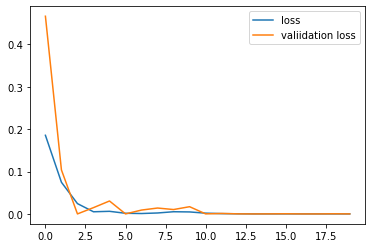

In [10]:
# analysizing model rsults by plotting training and loss at each epoch
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='valiidation loss')
plt.legend()

# 5. Prediction Part
we split data into two parts
<ul>
    <li>Training (571)</li>
    <li>Testing  (21)</li>
</ul>
Now for precition starts from current batch from last 6 days(window = 6 which is 565 ) in training dataset and cover testing along n future days from testing.


In [11]:
# Forecasting 
prediction  = [] 
current_batch = scale_train[-seq_size:] # training dataset last 6 digits
current_batch = current_batch.reshape(1, seq_size, n_features) # reshape it


In [12]:

# predict future, beyond test dates 
future = 16
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:], [[current_pred]], axis =1)
    #print(current_batch)
    
print(len(test)+future)
print(len(prediction))

37
37


#### Inverse Tranformation

In [13]:
rescale_pred = scaler.inverse_transform(prediction) # Inverse transform to before scaling so we get actual numbers
time_series_array = test.index  #Get dates for test data
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#### Capture everything into Data Frame for ploting

In [14]:
df_forecast = pd.DataFrame(columns=['Actual confirmed','predicted'], index = time_series_array)# Create a dataframe to capture the forecast data

df_forecast.loc[:, 'predicted'] = rescale_pred[:,0]  
df_forecast.loc[:, 'Actual confirmed'] = test['confirmed']   
df_forecast

,Actual confirmed,predicted
2021-08-16,36888983,3.995719e+07
2021-08-17,37017890,4.010503e+07
2021-08-18,37155706,4.023255e+07
2021-08-19,37294179,4.035317e+07
2021-08-20,37613673,4.043545e+07
2021-08-21,37676354,4.052577e+07
2021-08-22,37709851,4.062765e+07
2021-08-23,37939682,4.074818e+07
2021-08-24,38074929,4.086096e+07
2021-08-25,38223075,4.097059e+07


#### Prediction method B

<AxesSubplot:title={'center':'prediction for next 7 days'}>

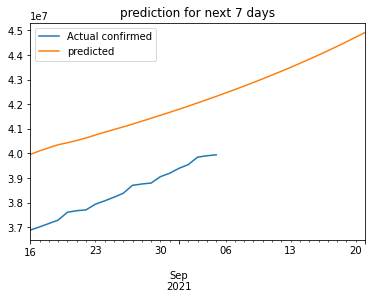

In [15]:
# plot it
df_forecast.plot(title='prediction for next 16 days')


# Refferences

Learning Source: https://www.youtube.com/watch?v=442BTP1_ZBw <br>
Dataset:
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv <br>
LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/